In [154]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
pd.set_option('display.max_colwidth', 600)
pd.set_option('display.max_rows', 150)
pd.set_option('display.width', 600)
plt.rcParams["figure.figsize"] = (14,5)

In [156]:
engine = create_engine('postgresql://mlanciau@localhost:5432/mlanciau')
conn = engine.connect();

In [157]:
percentage = 5/100

# Analytics on words (filtering on c_lang = 'en')

<AxesSubplot:ylabel='c_word'>

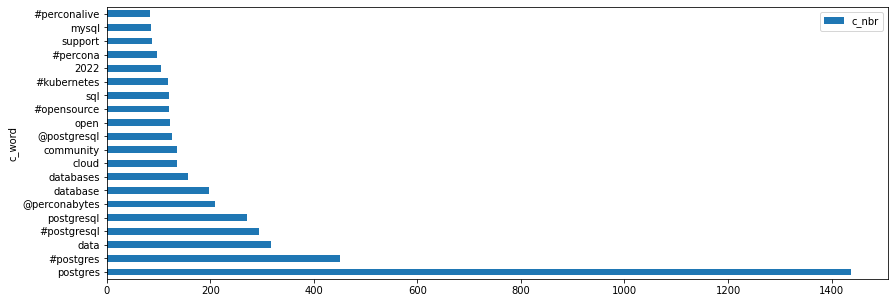

In [158]:
data = pd.read_sql(f'''
WITH tmp AS (
    SELECT c_word, c_category, COUNT(*) AS c_nbr
    FROM mlanciau_gold.t_twitter_postgresql_exploded_en
    WHERE c_lang = 'en'
    GROUP BY c_word, c_category
)

SELECT *
FROM tmp
WHERE c_nbr > (SELECT MAX(c_nbr)*{percentage} FROM tmp)
ORDER BY c_nbr DESC
LIMIT 20
''', conn)
data.plot.barh(x='c_word', y='c_nbr')

## Missing category (to be added to DBT seeds)

In [159]:
pd.read_sql(f'''
WITH tmp AS (
    SELECT c_word, c_category, COUNT(*) AS c_nbr
    FROM mlanciau_gold.t_twitter_postgresql_exploded_en
    WHERE c_lang = 'en'
    GROUP BY c_word, c_category
)

SELECT *
FROM tmp
WHERE c_category IS NULL AND c_nbr > (SELECT MAX(c_nbr)*{percentage} FROM tmp)
ORDER BY c_nbr DESC
''', conn)

,c_word,c_category,c_nbr
0,open,None,122
1,2022,None,105
2,live,None,83
3,things,None,81
4,know,None,81
5,stack,None,79
6,source,None,75
7,still,None,74


## What about those tweets (category is NULL or 'TO CHECK') then

In [160]:
pd.read_sql(f'''
WITH tmp AS (
    SELECT c_word, c_category, COUNT(*) AS c_nbr
    FROM mlanciau_gold.t_twitter_postgresql_exploded_en
    WHERE c_lang = 'en'
    GROUP BY c_word, c_category
)

-- to grab the full tweet
SELECT ssreq_2.*, p.*
FROM (
    -- to go back to uniq c_id
    SELECT t.c_id, MIN(ssreq_1.c_word) AS c_min_word, MAX(ssreq_1.c_word) AS c_max_word
    FROM (
        -- to study only key word we selected
        SELECT c_word
        FROM tmp
        WHERE c_nbr > (SELECT MAX(c_nbr)*{percentage} FROM tmp) AND c_category IS NULL OR c_category = 'TO CHECK'
        GROUP BY c_word
    ) ssreq_1
    INNER JOIN mlanciau_gold.t_twitter_postgresql_exploded_en t
    ON ssreq_1.c_word = t.c_word
    GROUP BY c_id
) ssreq_2
INNER JOIN mlanciau_gold.t_twitter_postgresql p
ON ssreq_2.c_id = p.c_id
ORDER BY p.c_id DESC
LIMIT 30
''', conn)

,c_id,c_min_word,c_max_word,c_id,c_text,c_lang,c_retweet,c_created_at,c_loaded_at,c_author_id
0,1524950633128017920,open,source,1524950633128017920,RT @nhostio: Nhost: The Open Source Firebase Alternative with GraphQL (and SQL):\n\n- Postgres\n- Hasura\n- Authentication\n- Storage\n- Function…,en,True,2022-05-13 03:12:17+00:00,2022-05-13 03:15:02.071869+00:00,3004929865
1,1524932089841328128,2022,2022,1524932089841328128,RT @PerconaBytes: Join the talk A Deep Dive Into #PostgreSQL Indexing by Percona’s Ibrar Ahmed on #PerconaLive 2022.\n\nRegister now:\nhttps:/…,en,True,2022-05-13 01:58:36+00:00,2022-05-13 02:20:02.455119+00:00,4839215822
2,1524930449713274881,2022,2022,1524930449713274881,RT @PerconaBytes: Join the talk A Deep Dive Into #PostgreSQL Indexing by Percona’s Ibrar Ahmed on #PerconaLive 2022.\n\nRegister now:\nhttps:/…,en,True,2022-05-13 01:52:05+00:00,2022-05-13 02:20:02.455119+00:00,1348558873636921349
3,1524930427378487296,2022,2022,1524930427378487296,Join the talk A Deep Dive Into #PostgreSQL Indexing by Percona’s Ibrar Ahmed on #PerconaLive 2022.\n\nRegister now:\nhttps://t.co/KlcTsSpwTf\n\n#databases #opensource #cloud #devops #MySQL #sql #nosql #k8s #Percona #Kubernetes #Postgres https://t.co/tBIoR5FukK,en,False,2022-05-13 01:52:00+00:00,2022-05-13 02:20:02.455119+00:00,1175125905829695488
4,1524925085517492224,know,know,1524925085517492224,@Meligy I know the @citusdata team work hard to contribute back to the core. I’m sure @clairegiordano can point you in the direction that shows how we’re making sure everyone benefits from our cloud-scale Postgres.,en,False,2022-05-13 01:30:46+00:00,2022-05-13 02:20:02.455119+00:00,37792239
5,1524920360604270592,know,know,1524920360604270592,"Your company can help support the PostgreSQL community by sponsoring PGConf NYC! We have sponsorships available from Bronze to Platinum levels, but it’s first come, first served! Let them know today!\n\nhttps://t.co/PXE7SGHXiw\n\n#PostgreSQL #postgres #conference #pgconfnyc",en,False,2022-05-13 01:12:00+00:00,2022-05-13 02:20:02.455119+00:00,1420795508407341058
6,1524919379854471170,know,know,1524919379854471170,RT @PerconaBytes: Charly Batista @elchinoBR from #Percona will present his talk Cleaning the Room - Everything You Need To Know About Vacuu…,en,True,2022-05-13 01:08:06+00:00,2022-05-13 02:20:02.455119+00:00,1425764869106585600
7,1524906597847158784,know,know,1524906597847158784,"i managed to make it works, in Postgres the default schema is 'public' which i did not know, so what's the deal, it is fast when it the query is supported, see example here https://t.co/nRcgqrrtNc",en,False,2022-05-13 00:17:18+00:00,2022-05-13 02:20:02.455119+00:00,796152745203929089
8,1524895132155146245,stack,stack,1524895132155146245,RT @EDBPostgres: #CloudNativePG ensures that everyone can start using an entirely #opensource stack for #Postgres in #Kubernetes for all th…,en,True,2022-05-12 23:31:45+00:00,2022-05-13 02:20:02.455119+00:00,3149381
9,1524884876561899540,2022,2022,1524884876561899540,Join the talk Evaluating #PostgreSQL Compatibility in Distributed SQL #Databases by Denis Magda from @Yugabyte on #PerconaLive 2022.\n\nRegister now:\nhttps://t.co/KlcTsS7W1H\n\n#databases #opensource #cloud #devops #MySQL #sql #nosql #k8s #Percona #Kubernetes #Postgres https://t.co/08fe5nWg8M,en,False,2022-05-12 22:51:00+00:00,2022-05-13 02:20:02.455119+00:00,1175125905829695488


## Evolution on 5 day 

In [161]:
data = pd.read_sql(f'''
WITH all_word_per_date_per_category AS (
    SELECT c_word, c_date, c_category, COUNT(*) AS c_nbr
    FROM mlanciau_gold.t_twitter_postgresql_exploded_en
    WHERE c_lang = 'en'
    GROUP BY c_word, c_date, c_category
),

all_date AS (
   SELECT c_date
   FROM all_word_per_date_per_category
   GROUP BY c_date
),

all_word AS (
    SELECT c_word
    FROM all_word_per_date_per_category
    GROUP BY c_word
),

all_word_all_date AS (
    SELECT all_word.c_word, all_date.c_date, all_word_per_date_per_category.c_category, CASE WHEN c_nbr IS NULL THEN 0 ELSE c_nbr END AS c_nbr
    FROM all_word
    INNER JOIN all_date
    ON 1 = 1
    LEFT OUTER JOIN all_word_per_date_per_category
    ON all_word.c_word = all_word_per_date_per_category.c_word
        AND all_date.c_date = all_word_per_date_per_category.c_date
)
SELECT *
FROM (
    SELECT *, SUM(c_nbr) OVER(PARTITION BY c_word ORDER BY c_date ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING) AS c_nbr_5_days
    FROM all_word_all_date
    WHERE c_category IS NULL
) ssreq
WHERE c_nbr_5_days > 5
ORDER BY c_nbr_5_days DESC
LIMIT 100
''', conn)

In [162]:
data

,c_word,c_date,c_category,c_nbr,c_nbr_5_days
0,open,2022-05-10,None,11,84.0
1,open,2022-05-11,None,32,83.0
2,open,2022-05-12,None,32,76.0
3,2022,2022-05-10,None,5,70.0
4,2022,2022-05-11,None,23,66.0
5,open,2022-05-13,None,1,65.0
6,open,2022-05-09,None,7,58.0
7,multiple,2022-05-06,None,43,56.0
8,things,2022-05-03,None,6,55.0
9,multiple,2022-05-05,None,1,55.0


# Analytics on words (filtering on c_lang = 'en' and no retweet)

In [163]:
pd.read_sql(f'''
WITH tmp AS (
    SELECT c_word, c_category, COUNT(*) AS c_nbr
    FROM mlanciau_gold.t_twitter_postgresql_exploded_en
    WHERE c_lang = 'en' AND c_retweet = False
    GROUP BY c_word, c_category
)

SELECT *
FROM tmp
WHERE c_nbr > (SELECT MAX(c_nbr)*{percentage} FROM tmp)
ORDER BY c_nbr DESC
LIMIT 30
''', conn)

,c_word,c_category,c_nbr
0,postgres,Current semantic,911
1,#postgres,hashtag,300
2,#postgresql,hashtag,172
3,data,IT semantic,158
4,database,Current semantic,125
5,postgresql,Current semantic,120
6,#opensource,hashtag,92
7,sql,IT semantic,86
8,#kubernetes,hashtag,72
9,#percona,hashtag,66


## Missing category

In [164]:
pd.read_sql(f'''
WITH tmp AS (
    SELECT c_word, c_category, COUNT(*) AS c_nbr
    FROM mlanciau_gold.t_twitter_postgresql_exploded_en
    WHERE c_lang = 'en' AND c_retweet = False
    GROUP BY c_word, c_category
)

SELECT *
FROM tmp
WHERE c_category IS NULL AND c_nbr > (SELECT MAX(c_nbr)*{percentage} FROM tmp)
ORDER BY c_nbr DESC
''', conn)

,c_word,c_category,c_nbr
0,2022,None,49


## What about those tweets (category is NULL or 'TO CHECK') then

In [165]:
pd.read_sql(f'''
WITH tmp AS (
    SELECT c_word, c_category, COUNT(*) AS c_nbr
    FROM mlanciau_gold.t_twitter_postgresql_exploded_en
    WHERE c_lang = 'en' AND c_retweet = False
    GROUP BY c_word, c_category
)

-- to grab the full tweet
SELECT ssreq_2.*, p.*
FROM (
    -- to go back to uniq c_id
    SELECT t.c_id, MIN(ssreq_1.c_word) AS c_min_word, MAX(ssreq_1.c_word) AS c_max_word
    FROM (
        -- to study only key word we selected
        SELECT c_word
        FROM tmp
        WHERE c_nbr > (SELECT MAX(c_nbr)*{percentage} FROM tmp) AND c_category IS NULL OR c_category = 'TO CHECK'
        GROUP BY c_word
    ) ssreq_1
    INNER JOIN mlanciau_gold.t_twitter_postgresql_exploded_en t
    ON ssreq_1.c_word = t.c_word
    GROUP BY c_id
) ssreq_2
INNER JOIN mlanciau_gold.t_twitter_postgresql p
ON ssreq_2.c_id = p.c_id
ORDER BY p.c_id DESC
LIMIT 30
''', conn)

,c_id,c_min_word,c_max_word,c_id,c_text,c_lang,c_retweet,c_created_at,c_loaded_at,c_author_id
0,1524932089841328128,2022,2022,1524932089841328128,RT @PerconaBytes: Join the talk A Deep Dive Into #PostgreSQL Indexing by Percona’s Ibrar Ahmed on #PerconaLive 2022.\n\nRegister now:\nhttps:/…,en,True,2022-05-13 01:58:36+00:00,2022-05-13 02:20:02.455119+00:00,4839215822
1,1524930449713274881,2022,2022,1524930449713274881,RT @PerconaBytes: Join the talk A Deep Dive Into #PostgreSQL Indexing by Percona’s Ibrar Ahmed on #PerconaLive 2022.\n\nRegister now:\nhttps:/…,en,True,2022-05-13 01:52:05+00:00,2022-05-13 02:20:02.455119+00:00,1348558873636921349
2,1524930427378487296,2022,2022,1524930427378487296,Join the talk A Deep Dive Into #PostgreSQL Indexing by Percona’s Ibrar Ahmed on #PerconaLive 2022.\n\nRegister now:\nhttps://t.co/KlcTsSpwTf\n\n#databases #opensource #cloud #devops #MySQL #sql #nosql #k8s #Percona #Kubernetes #Postgres https://t.co/tBIoR5FukK,en,False,2022-05-13 01:52:00+00:00,2022-05-13 02:20:02.455119+00:00,1175125905829695488
3,1524884876561899540,2022,2022,1524884876561899540,Join the talk Evaluating #PostgreSQL Compatibility in Distributed SQL #Databases by Denis Magda from @Yugabyte on #PerconaLive 2022.\n\nRegister now:\nhttps://t.co/KlcTsS7W1H\n\n#databases #opensource #cloud #devops #MySQL #sql #nosql #k8s #Percona #Kubernetes #Postgres https://t.co/08fe5nWg8M,en,False,2022-05-12 22:51:00+00:00,2022-05-13 02:20:02.455119+00:00,1175125905829695488
4,1524863265679065106,2022,2022,1524863265679065106,RT @PerconaBytes: Hamid Akhtar will present three talks at Percona Live 2022. Get a preview now!\nhttps://t.co/bAmqZAXmZ1\n\n#Percona #openso…,en,True,2022-05-12 21:25:07+00:00,2022-05-13 02:20:02.455119+00:00,1172357958048632837
5,1524854426078429186,2022,2022,1524854426078429186,Hamid Akhtar @EngineeredVirus from #Percona will present his talk #PostgreSQL Query Performance Insights on #PerconaLive 2022.\n\nRegister now:\nhttps://t.co/KlcTsS7W1H\n\n#databases #opensource #cloud #devops #MySQL #sql #nosql #k8s #Percona #Kubernetes #Postgres #PostgreSQL https://t.co/hBfClt2f2w,en,False,2022-05-12 20:50:00+00:00,2022-05-13 02:20:02.455119+00:00,1175125905829695488
6,1524827089312043018,2022,2022,1524827089312043018,RT @PerconaBytes: Hamid Akhtar will present three talks at Percona Live 2022. Get a preview now!\nhttps://t.co/bAmqZAXmZ1\n\n#Percona #openso…,en,True,2022-05-12 19:01:22+00:00,2022-05-12 19:40:02.612367+00:00,1294586076997222405
7,1524826767776784385,2022,2022,1524826767776784385,RT @PerconaBytes: Hamid Akhtar will present three talks at Percona Live 2022. Get a preview now!\nhttps://t.co/bAmqZAXmZ1\n\n#Percona #openso…,en,True,2022-05-12 19:00:06+00:00,2022-05-12 19:40:02.612367+00:00,1348558873636921349
8,1524826745580314626,2022,2022,1524826745580314626,Hamid Akhtar will present three talks at Percona Live 2022. Get a preview now!\nhttps://t.co/bAmqZAXmZ1\n\n#Percona #opensource #database #RoadToPerconaLive #Postgres https://t.co/ZvnJmLIOjl,en,False,2022-05-12 19:00:00+00:00,2022-05-12 19:40:02.612367+00:00,1175125905829695488
9,1524801540338352130,2022,2022,1524801540338352130,RT @PerconaBytes: Get some tips about to-do-list while you are in Austin for Road to Percona Live 2022 on May 16th-18th\n\nhttps://t.co/eLDXc…,en,True,2022-05-12 17:19:51+00:00,2022-05-12 19:40:02.612367+00:00,1348558873636921349


In [166]:
conn.close()